In [210]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from prophet import Prophet
import pandas as pd
import numpy as np

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import sys  
sys.path.insert(0, '../../')
import RadonDF_Handler

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [211]:
D001_df = pd.read_csv('./../../../../../Data/SensorsData/interpolated_D001_data.csv')
D001_df = D001_df.iloc[913:]
D001_df
D001_df['time'] =  pd.to_datetime(D001_df['time'], format='%Y-%m-%d %H:%M:%S')
D001_df.rename(columns = {'Rn':'y','time':'ds'}, inplace = True)
D001_df = D001_df.reset_index(drop=True)
D001_df
# D001_df.index = D001_df['time']
# D001_df = D001_df.drop(['time'],axis = 1)
# D001_df.index = D001_df.index.rename('ds')
# D001_df.rename(columns = {'Rn':'y'}, inplace = True)
# D001_columns = list(D001_df.columns)
# D001_columns[0],D001_columns[1] = D001_columns[1],D001_columns[0]
# D001_df = D001_df[D001_columns]

,ds,T,y,H,P,CO2
0,2019-07-05 15:00:00,33.304737,10.995556,32.315789,101.571263,29.263158
1,2019-07-05 16:00:00,33.566316,10.340526,33.157895,101.553895,28.894737
2,2019-07-05 17:00:00,33.453500,9.654000,32.050000,101.534200,28.150000
3,2019-07-05 18:00:00,33.578947,10.009474,32.526316,101.527526,28.789474
4,2019-07-05 19:00:00,33.745789,13.413684,32.947368,101.523500,29.684211
...,...,...,...,...,...,...
8542,2021-08-18 08:00:00,22.772000,145.034000,60.800000,101.978200,138.800000
8543,2021-08-18 09:00:00,22.665000,226.328000,61.500000,101.960600,137.400000
8544,2021-08-18 10:00:00,22.703750,247.572500,60.875000,101.922750,136.375000
8545,2021-08-23 08:00:00,23.290000,330.400000,63.000000,101.663000,169.000000


In [212]:
D001_df

,ds,T,y,H,P,CO2
0,2019-07-05 15:00:00,33.304737,10.995556,32.315789,101.571263,29.263158
1,2019-07-05 16:00:00,33.566316,10.340526,33.157895,101.553895,28.894737
2,2019-07-05 17:00:00,33.453500,9.654000,32.050000,101.534200,28.150000
3,2019-07-05 18:00:00,33.578947,10.009474,32.526316,101.527526,28.789474
4,2019-07-05 19:00:00,33.745789,13.413684,32.947368,101.523500,29.684211
...,...,...,...,...,...,...
8542,2021-08-18 08:00:00,22.772000,145.034000,60.800000,101.978200,138.800000
8543,2021-08-18 09:00:00,22.665000,226.328000,61.500000,101.960600,137.400000
8544,2021-08-18 10:00:00,22.703750,247.572500,60.875000,101.922750,136.375000
8545,2021-08-23 08:00:00,23.290000,330.400000,63.000000,101.663000,169.000000


In [213]:
training_data = D001_df.sample(frac=0.8, random_state=25)
testing_data = D001_df.drop(training_data.index)
testing_data = testing_data.reset_index(drop=True)

testing_data_v2 = testing_data[['ds','T','H','P','CO2']]
testing_data_v2 = testing_data.reset_index(drop=True)


print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 6838
No. of testing examples: 1709


In [214]:
testing_data_v2

,ds,T,y,H,P,CO2
0,2019-07-06 02:00:00,30.311053,1.343684,38.736842,101.459789,28.157895
1,2019-07-06 05:00:00,29.944211,14.673158,38.368421,101.397526,28.421053
2,2019-07-06 14:00:00,32.916000,7.504000,35.300000,101.408400,28.300000
3,2019-07-06 23:00:00,33.608000,12.134000,34.200000,101.501400,28.800000
4,2019-07-07 07:00:00,31.205000,8.139000,37.900000,101.409300,30.700000
...,...,...,...,...,...,...
1704,2021-08-17 01:00:00,22.851000,72.357000,63.200000,102.179800,112.500000
1705,2021-08-17 09:00:00,22.909000,114.080000,62.000000,102.316100,133.300000
1706,2021-08-17 20:00:00,23.033636,49.671818,60.727273,102.012727,89.000000
1707,2021-08-18 01:00:00,22.834444,58.085556,61.888889,101.934111,108.666667


In [215]:
model = Prophet()
model.add_regressor('T',standardize = False)
model.add_regressor('H',standardize = False)
model.add_regressor('P',standardize = False)
model.add_regressor('CO2',standardize = False)

In [216]:
model.fit(training_data)

C:\Users\valdo\anaconda3\envs\RnHealth\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [217]:
forecast = model.predict(testing_data_v2)
forecast = forecast[['ds','yhat']]

C:\Users\valdo\anaconda3\envs\RnHealth\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\valdo\anaconda3\envs\RnHealth\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [218]:
testing_data

,ds,T,y,H,P,CO2
0,2019-07-06 02:00:00,30.311053,1.343684,38.736842,101.459789,28.157895
1,2019-07-06 05:00:00,29.944211,14.673158,38.368421,101.397526,28.421053
2,2019-07-06 14:00:00,32.916000,7.504000,35.300000,101.408400,28.300000
3,2019-07-06 23:00:00,33.608000,12.134000,34.200000,101.501400,28.800000
4,2019-07-07 07:00:00,31.205000,8.139000,37.900000,101.409300,30.700000
...,...,...,...,...,...,...
1704,2021-08-17 01:00:00,22.851000,72.357000,63.200000,102.179800,112.500000
1705,2021-08-17 09:00:00,22.909000,114.080000,62.000000,102.316100,133.300000
1706,2021-08-17 20:00:00,23.033636,49.671818,60.727273,102.012727,89.000000
1707,2021-08-18 01:00:00,22.834444,58.085556,61.888889,101.934111,108.666667


In [219]:
forecast

,ds,yhat
0,2019-07-06 02:00:00,137.447733
1,2019-07-06 05:00:00,141.293964
2,2019-07-06 14:00:00,177.915904
3,2019-07-06 23:00:00,161.619594
4,2019-07-07 07:00:00,195.618268
...,...,...
1704,2021-08-17 01:00:00,121.826574
1705,2021-08-17 09:00:00,143.047428
1706,2021-08-17 20:00:00,91.254525
1707,2021-08-18 01:00:00,95.550300


In [220]:
comparation_df = pd.concat((pd.DataFrame(forecast['yhat']),testing_data),axis = 1)

In [222]:
comparation_df 

,yhat,ds,T,y,H,P,CO2
0,137.447733,2019-07-06 02:00:00,30.311053,1.343684,38.736842,101.459789,28.157895
1,141.293964,2019-07-06 05:00:00,29.944211,14.673158,38.368421,101.397526,28.421053
2,177.915904,2019-07-06 14:00:00,32.916000,7.504000,35.300000,101.408400,28.300000
3,161.619594,2019-07-06 23:00:00,33.608000,12.134000,34.200000,101.501400,28.800000
4,195.618268,2019-07-07 07:00:00,31.205000,8.139000,37.900000,101.409300,30.700000
...,...,...,...,...,...,...,...
1704,121.826574,2021-08-17 01:00:00,22.851000,72.357000,63.200000,102.179800,112.500000
1705,143.047428,2021-08-17 09:00:00,22.909000,114.080000,62.000000,102.316100,133.300000
1706,91.254525,2021-08-17 20:00:00,23.033636,49.671818,60.727273,102.012727,89.000000
1707,95.550300,2021-08-18 01:00:00,22.834444,58.085556,61.888889,101.934111,108.666667


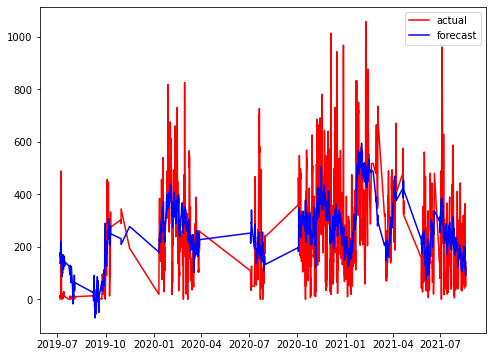

In [223]:
plt.figure(figsize=(8,6))
plt.plot(comparation_df['ds'],comparation_df['y'],color = 'red',label = 'actual')
plt.plot(comparation_df['ds'],comparation_df['yhat'],color = 'blue',label = 'forecast')
plt.legend()